In [2]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

In [3]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gzip
import pandas as pd
import anndata
import torch

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cell2location.__version__

'0.1.4'

In [5]:
#folder = "/home/linxy29/data/spaceclone/cSCC/"
folder = "/home/linxy29/data/CIVET"
sample_name = "visium_breastcancer_10x"
results_folder = f'{folder}/{sample_name}/cell2location/'
# create the results folder if it doesn't exist
import os
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{folder}/breastcancer_atlas/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

### Loading Visium and scRNA-seq reference data

In [6]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File /home/linxy29/data/CIVET/breastcancer_atlas/reference_signatures/model.pt already downloaded         


/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trai

Epoch 1/200:   0%|          | 1/200 [00:02<08:43,  2.63s/it, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/200:   0%|          | 1/200 [00:02<08:46,  2.65s/it, v_num=1]


### Visualising cell abundance in spatial coordinates

In [7]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File /home/linxy29/data/CIVET/visium_breastcancer_10x/cSCC_cell2location//cell2location_map/model.pt      
         already downloaded                                                                                        


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if 

Epoch 1/30000:   0%|          | 1/30000 [00:02<21:35:42,  2.59s/it, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:02<21:39:38,  2.60s/it, v_num=1]


In [10]:
adata_vis = mod.export_posterior(adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs})

Sampling global variables, sample: 100%|██████████| 999/999 [02:24<00:00,  6.93it/s]


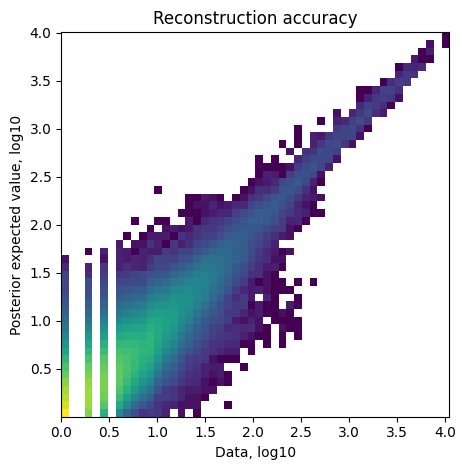

In [13]:
mod.plot_QC()

In [12]:
adata_vis

AnnData object with n_obs × n_vars = 4169 × 12682
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence', 'MT_gene'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [17]:
## calculate the cell number
celltype_counts = adata_ref.obs['celltype_minor'].value_counts()
## sort the cell types by the number of cells
celltype_counts = celltype_counts.sort_values(ascending=False)
celltype_counts
## select cell types that start with 'Tumor'
celltype_counts_sub1 = celltype_counts[celltype_counts.index.str.startswith('Cancer')]
## slect rest of the cell types
celltype_counts_sub2 = celltype_counts[~celltype_counts.index.str.startswith('Cancer')]
## combine the two subsets
celltype_counts = pd.concat([celltype_counts_sub1, celltype_counts_sub2])
celltype_counts

#celltype = adata_ref.obs['level3_celltype'].unique()

celltype_minor
Cancer_LumA_SC                  7742
Cancer_Cycling                  5359
Cancer_Basal_SC                 4312
Cancer_Her2_SC                  3708
Cancer_LumB_SC                  3368
T_cells_CD4+                   19231
T_cells_CD8+                   11487
Macrophage                      5929
Endothelial_ACKR1               4611
Plasmablasts                    3524
PVL_Differentiated              3487
CAFs_myCAF-like                 3420
CAFs_MSC_iCAF-like              3153
B_cells_Memory                  2581
Monocyte                        2328
Luminal_Progenitors             1992
PVL_Immature                    1886
NK_cells                        1846
Endothelial_CXCL12              1644
Cycling_T-cells                 1528
Mature_Luminal                  1265
Endothelial_RGS5                1147
NKT_cells                       1122
Myoepithelial                   1098
DCs                              955
B_cells_Naive                    625
Cycling_Myeloid        

In [18]:
celltype_counts.index[:8]

CategoricalIndex(['Cancer_LumA_SC', 'Cancer_Cycling', 'Cancer_Basal_SC',
                  'Cancer_Her2_SC', 'Cancer_LumB_SC', 'T_cells_CD4+',
                  'T_cells_CD8+', 'Macrophage'],
                 categories=['B_cells_Memory', 'B_cells_Naive', 'CAFs_MSC_iCAF-like', 'CAFs_myCAF-like', ..., 'PVL_Immature', 'Plasmablasts', 'T_cells_CD4+', 'T_cells_CD8+'], ordered=False, dtype='category', name='celltype_minor')

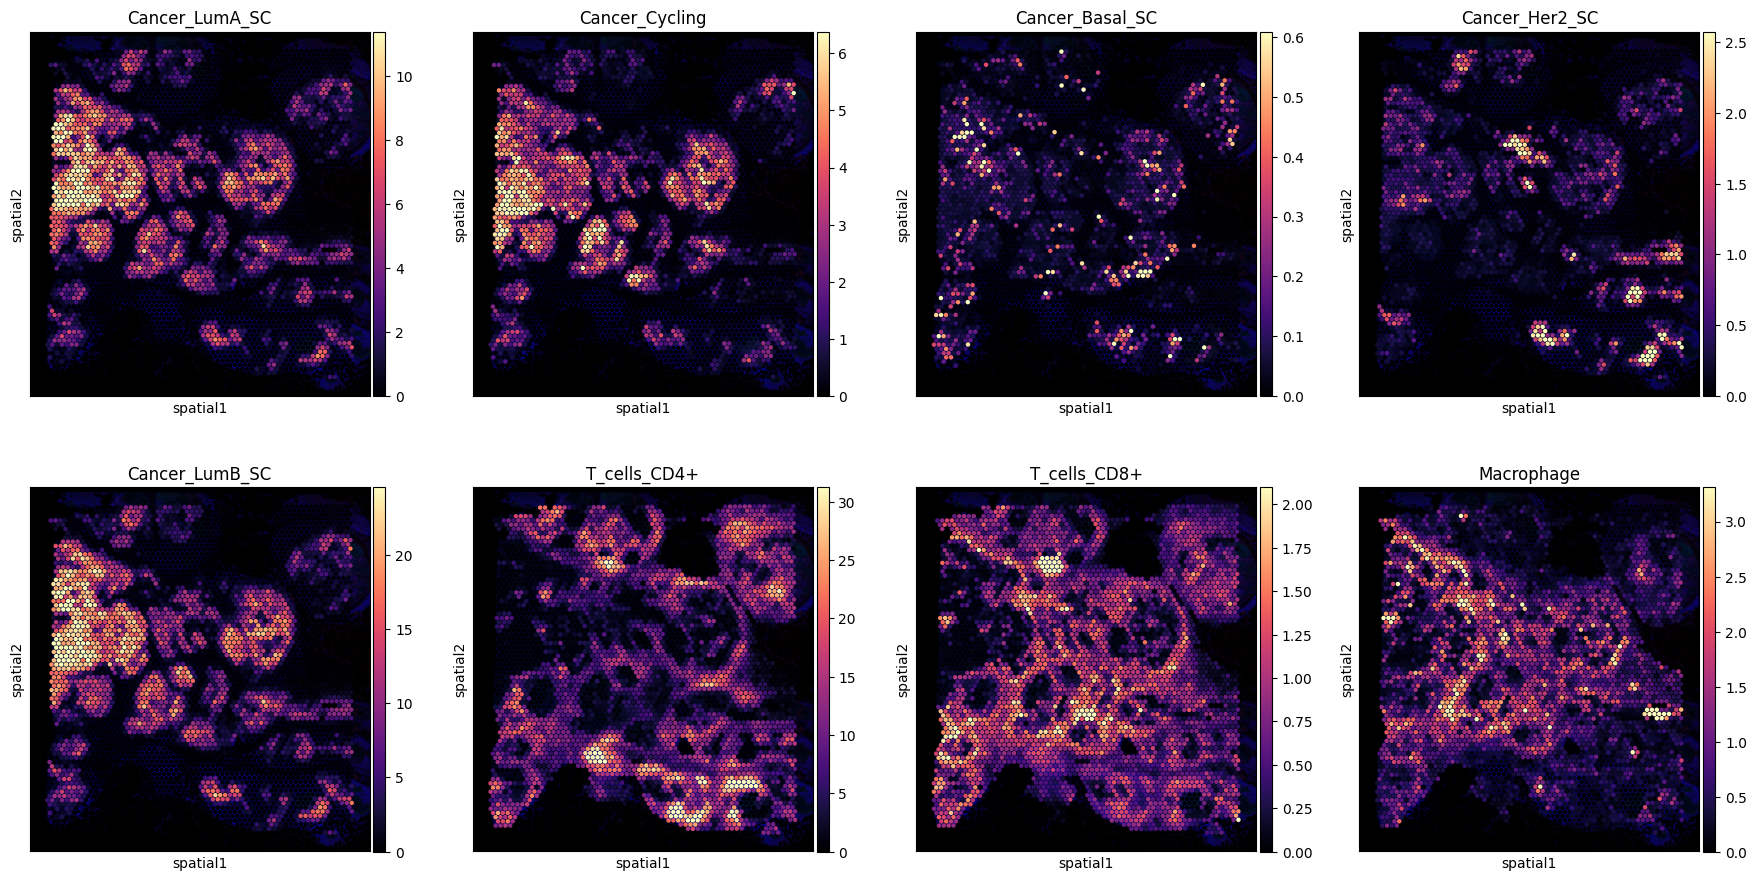

<Figure size 450x500 with 0 Axes>

In [24]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
#from cell2location.utils import select_slide
#slide = select_slide(adata_vis, sample_name)
slide = adata_vis

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=celltype_counts.index[:8],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

    plt.savefig(f"{run_name}/cell_abundance_map_oneCellType.pdf", bbox_inches='tight')

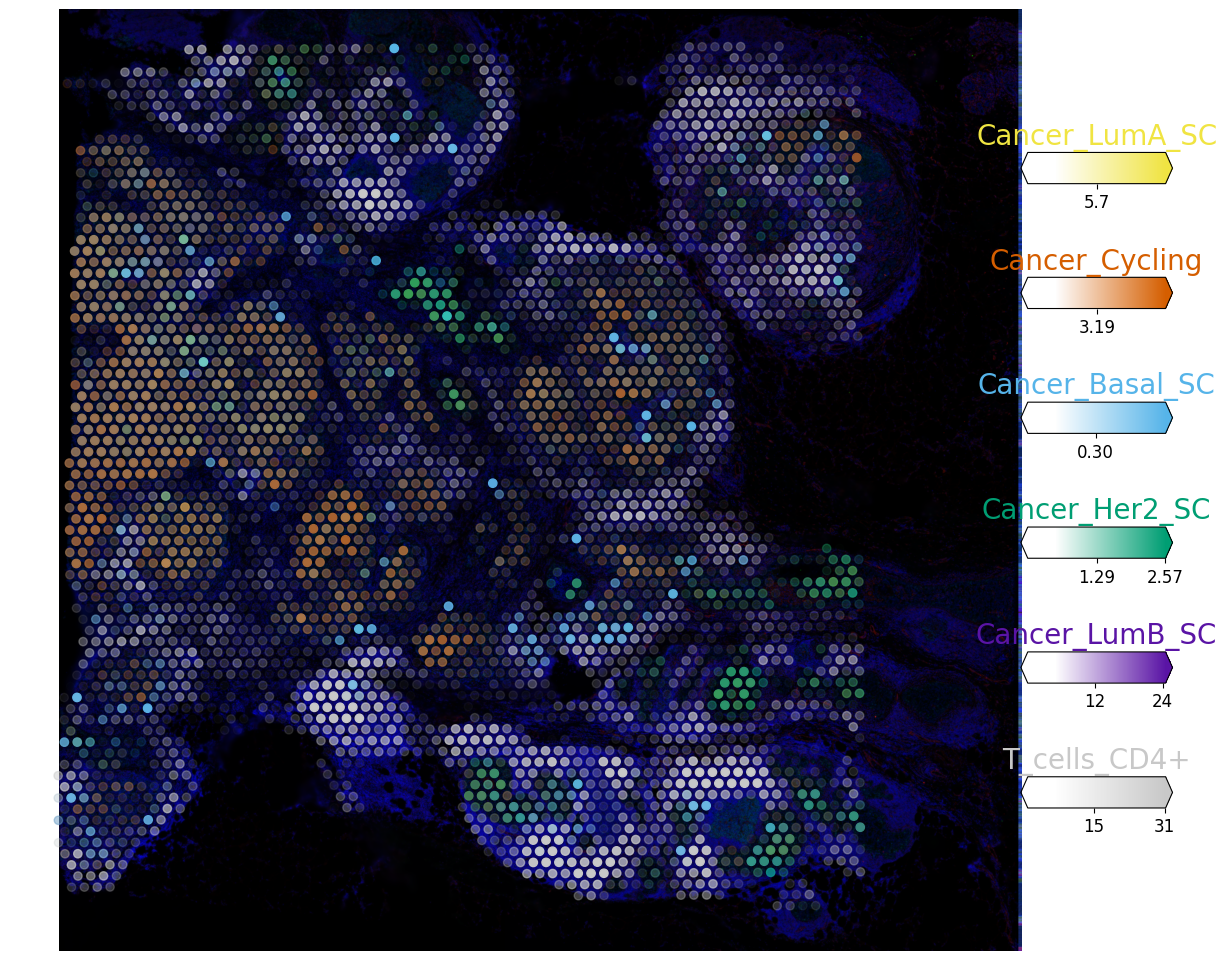

In [20]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = celltype_counts.index[:6]
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

#slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )
    fig.savefig(f"{run_name}/cell_abundance_map_sixCellType.pdf", bbox_inches='tight')

In [25]:
adata_vis.obsm['q05_cell_abundance_w_sf'].to_csv(f"{run_name}/q05_cell_abundance.csv", index=True)

## Downstream analysis

In [52]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

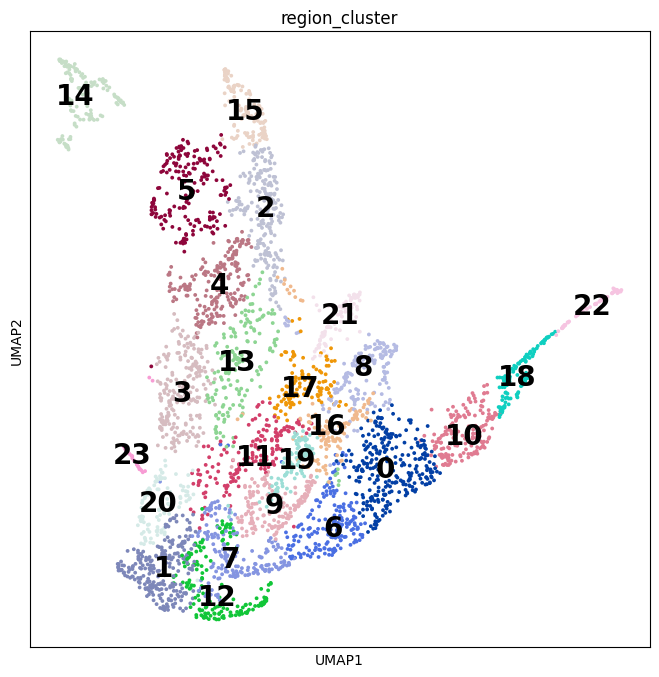

In [53]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    fig = sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20, save = sample_name + "_spatial_umap.pdf")

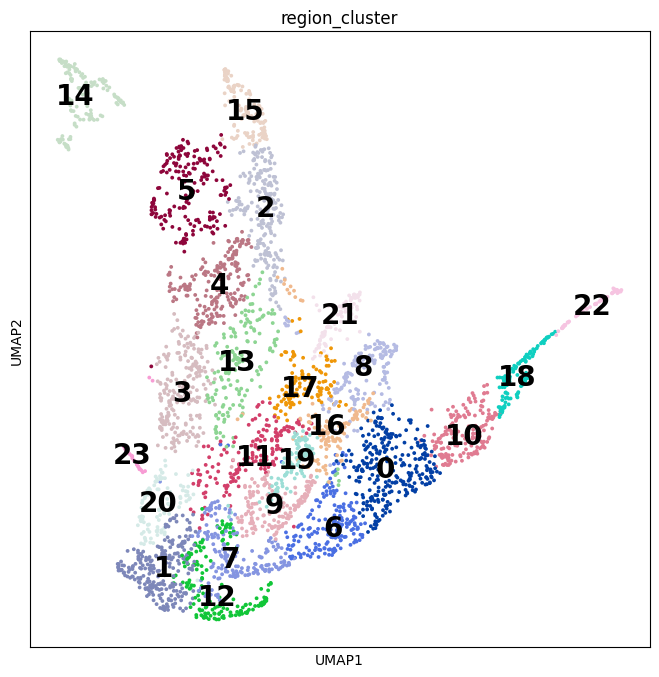

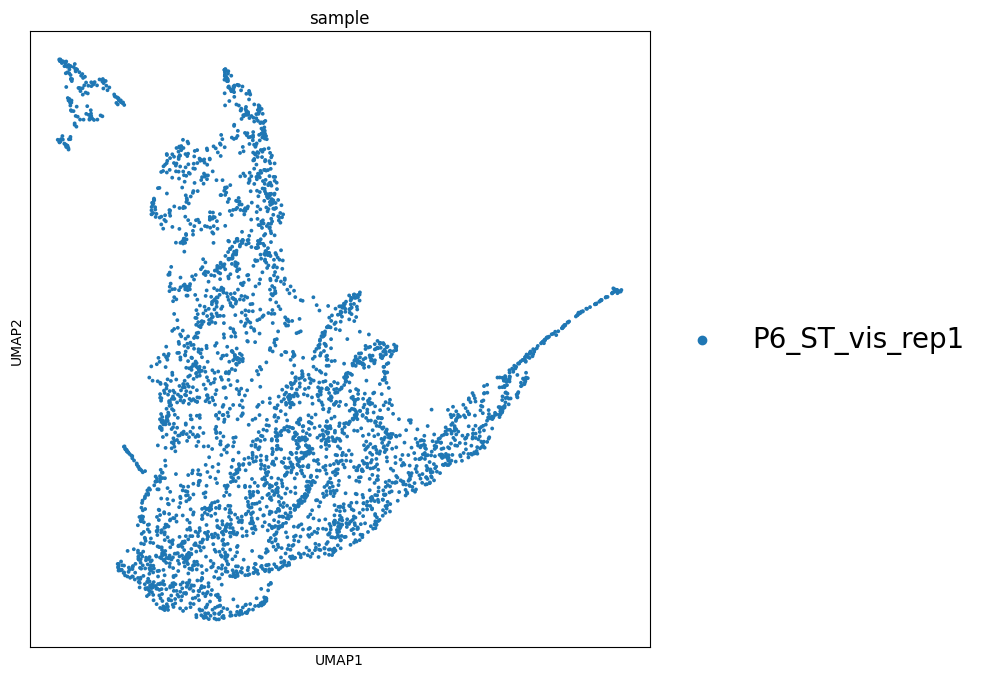

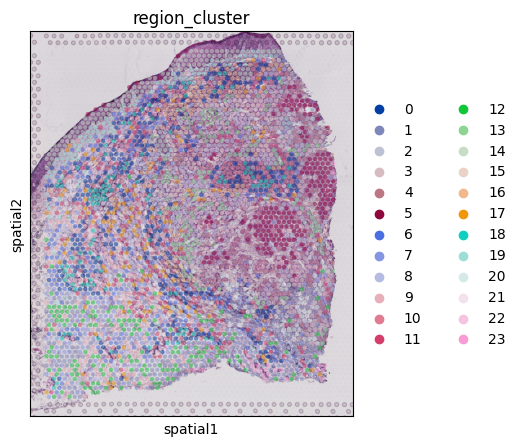

<Figure size 640x480 with 0 Axes>

In [54]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    fig = sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20, save = sample_name + "_spatial_umap.pdf")

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)
plt.savefig(f"{run_name}/region_map.pdf", bbox_inches='tight')

### Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

In [55]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_3719locations_35factors


/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_3719locations_35factors


/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0


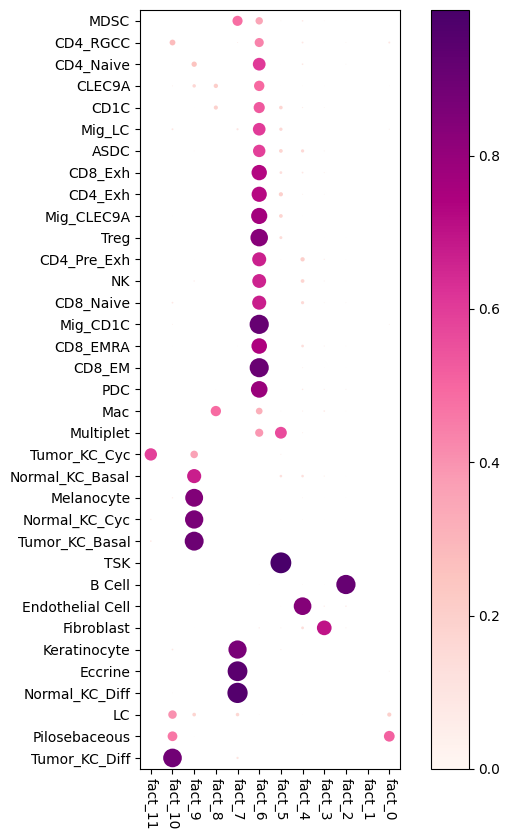

In [56]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()
plt.savefig(f"{run_name}/CoLocatedComb/CoLocatedGroupsSklearnNMF_cell_type_fractions_heatmap.pdf", bbox_inches='tight')

In [57]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'/home/linxy29/holab/linxy/maester/spaceclone/cSCC/cSCC_cell2location/P6_ST_vis_rep1/cell2location_map/sp.h5ad'

In [58]:
# list cell types and genes for plotting
ctypes = celltype_counts.index[:6]
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    #slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);

ModuleNotFoundError: No module named 'tutorial_utils'

### Advanced use

In [ ]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

In [ ]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs, use_gpu=True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');